In [5]:
%pip install geopandas rasterio rasterstats shapely fiona ipyleaflet geemap
%pip install folium earthengine-api
%pip install scikit-learn

In [6]:
from os import path as op
import pickle
import fiona
import geemap
import ipyleaflet
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window
import rasterstats
import folium


In [7]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [8]:
!earthengine authenticate
import ee 
ee.Initialize()

Instructions for updating:
non-resource variables are not supported in the long term
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=B2ZX9n6Xf_6LAC9xpHZdtyl6MfvowqfCg-NqjDRLWww&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgDtWQTo4z2eq0GSjVq5UkvElev_Pih0kevX4BARx0GddbO9NTSRgY

Successfully saved authorization token.


In [9]:
my_root_dir = "/content/drive/My Drive/"

In [10]:
c = fiona.open('/content/drive/My Drive/Colab Notebooks/data/ind_shape/ind_shape.shp')
#xx=ee.FeatureCollection(c)
polygons = []

for row in c:
  polygons.append(row['geometry']['coordinates'])

In [11]:
aoi=ee.Geometry.Polygon(polygons[0])

In [22]:
s2=ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2')
collection = s2.select('NO2_column_number_density').filterBounds(aoi)
def display_(start_date,end_date,i):
  cc=collection.filterDate(start_date, end_date).mean()
  clip=cc.clip(aoi)
  clip_mean=clip.reduce(ee.Reducer.mean())
  # Display the NO2 level in India.
  str1='NO2 Concentration before Lockdown from Jan 01 to jan 30'
  str2='NO2 Concentration During Lockdown from June 01 to june 30'
  str3='NO2 Concentration After Lockdown from Dec 01 to Dec 30'
  if i==1:
    print(str1)
  if i==2:
    print(str2)
  if i==3:
    print(str3)
  from IPython.display import Image
  # Create a URL to the styled image for a region around France.
  url = clip_mean.getThumbUrl({'min': 0.00, 'max': 0.00017, 'dimensions': 512, 'region': aoi, 'palette':['black','blue','purple','cyan','green','yellow','red']})
  return url



In [23]:
from IPython.display import Image
Image(url=display_('2020-01-01','2020-01-30',1))


NO2 Concentration before Lockdown from Jan 01 to jan 30


In [24]:
Image(url=display_('2020-06-01','2020-06-30',2))


NO2 Concentration During Lockdown from June 01 to june 30


In [25]:

Image(url=display_('2020-12-01','2020-12-30',3))

NO2 Concentration After Lockdown from Dec 01 to Dec 30


In [36]:
import pandas as pd


In [32]:
roi=ee.Geometry.Point(77.2308,28.6117).buffer(500)

In [33]:
def roi_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=roi, scale=30).get('NO2_column_number_density')
    return img.set('date', img.date().format()).set('mean',mean)

In [34]:
def monthly_mean_NO2(m):
  strt='2020-'+m+'-01'
  end='2020-'+m+'-28'
  collect=ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_NO2').filterDate(strt,end)
  roi_reduced_imgs = collect.map(roi_mean)
  nested_list = roi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)
  df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

  return (df['mean'].mean())

In [37]:
no=[]
month=['01','02','03','04','05','06','07','08','09','10','11','12']
for i in range(12):
  no.append(monthly_mean_NO2(month[i]))


In [38]:
y=no
x=month

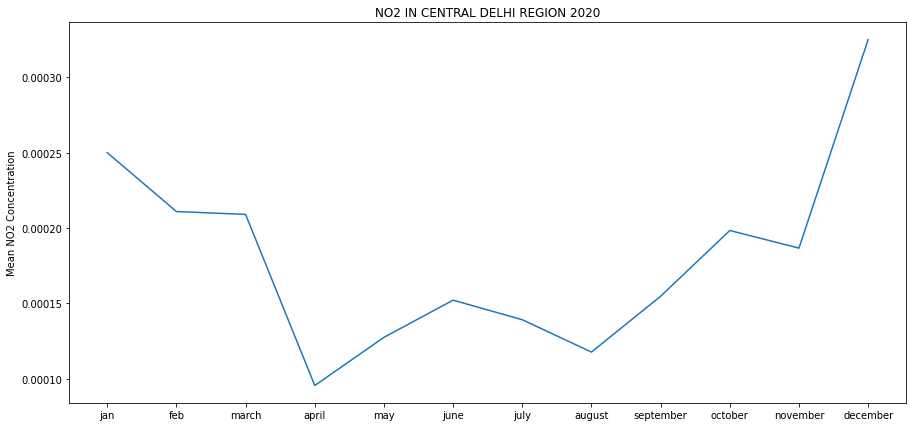

In [39]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(x,y)

x_ticks = x
x_labels = ['jan','feb','march','april','may','june','july','august','september','october','november','december']
plt.xticks(ticks=x_ticks, labels=x_labels)

plt.ylabel("Mean NO2 Concentration")
plt.title('NO2 IN CENTRAL DELHI REGION 2020')

plt.show()